# TEST

In [7]:
!pwd
isLocalServer = True

%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, sys, os

if isLocalServer is True:
  print(f'This is in the local server, therefore your folder path should be added to the system path.')
  
  sys_path_to_be_added = '/notebook/personal/ksuchoi216/FaceID-model/'
  if not sys_path_to_be_added in sys.path:
    sys.path.insert(0, sys_path_to_be_added)
    os.chdir(sys_path_to_be_added)

  print(f'System path as follows:')
  for path in sys.path:
    print(f'    {path}')

def load_config(filename):
  path_for_config = './configs/'+filename
  with open(path_for_config) as f:
    cfg = json.load(f)
  print(cfg)
  return cfg

cfg = load_config('config_test-various-face-extraction.json')

/notebook/personal/ksuchoi216/FaceID-model
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This is in the local server, therefore your folder path should be added to the system path.
System path as follows:
    /notebook/personal/ksuchoi216/FaceID-model/
    /notebook
    /root/.pyenv/versions/3.9.1/lib/python39.zip
    /root/.pyenv/versions/3.9.1/lib/python3.9
    /root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload
    
    /root/.pyenv/versions/python39/lib/python3.9/site-packages
{'data_source': './data/photos_cropped/', 'user_names': ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi'], 'theNumberOfImages': 100, 'save_folder_for_embedding_numpy': './data/', 'models': ['DeepID', 'ArcFace'], 'detector_backend': 'mtcnn'}


In [8]:
import numpy as np
# loading numpy data

def loadNumpyImagesToDict(user_names_list, data_source_path):
  user_names = user_names_list
  data_source = data_source_path

  numpy_data = {}
  print(numpy_data)
  for i, user_name in enumerate(user_names):
    print(i, user_name)
    file_path = data_source + user_name + '_images.npy'
    numpy_data[user_name] = np.load(file_path, allow_pickle=True)

  print('example dimension: {}'.format(numpy_data['jhyoo'].shape))


In [9]:
from PIL import Image
import matplotlib.pyplot as plt
from deepface import DeepFace

models = cfg['models']

data_source = cfg['data_source']
user_names = cfg['user_names']
theNumberOfImages = cfg['theNumberOfImages']
save_folder_for_embedding_numpy = cfg['save_folder_for_embedding_numpy']
detector_backend = cfg['detector_backend']
print(user_names)
print(theNumberOfImages)
print(f'model length: {len(models)}')
print(models)

['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']
100
model length: 2
['DeepID', 'ArcFace']


In [10]:
# embedding data to be saved as numpy type
''' embedding numpy matrix form
options are presented as follows:

models = [
  "VGG-Face", 
  "Facenet", 
  "Facenet512", 
  "OpenFace", 
  "DeepFace", 
  "DeepID", 
  "ArcFace", 
  "Dlib", 
  "SFace",
]

backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe'
]


      label---models---
      +---+-----------+
      | 0 |           |
data  | 0 |           |
      | 0 |           |
      | 1 |           |
      +---+-----------+
'''

for model_num in range(len(models)):
  print(f'starting for {models[model_num]}')    
  emb_numpy_matrix = np.zeros(shape = (theNumberOfImages * len(user_names), len(models)+1))

  for label, user_name in enumerate(user_names):
    print(f'{user_name}... in progress')
      
    
    emb_numpy_cols = np.zeros(shape = (theNumberOfImages, 1))
    # print(f'emb_numpy_cols shape: {emb_numpy_cols.shape}')
    emb_numpy_cols[:, 0] = label
    
    emb_list_col = []
    count = 0
    for num in range(theNumberOfImages+100):
      print('num...:', num)
      if count >= theNumberOfImages:
        break
      img_path = data_source + user_name + '/' + str(num+1) + '.png'

      emb = DeepFace.represent(img_path=img_path, model_name = models[model_num], enforce_detection=False, detector_backend = detector_backend)
      emb_list_col.append(np.array(emb))
      count += 1
      print(f'[{num}] model: {models[model_num]} count: {count}')
 
    emb_numpy_col = np.asarray(emb_list_col)
    print(f'emb_numpy_col shape: {emb_numpy_col.shape}')
    
    if label == 0:
      cols = int(emb_numpy_col.shape[1]) + 1 # 1 is for the label column
      emb_numpy_matrix = np.zeros(shape=(1, cols))
      # print(f'emb_numpy_matrix shape: {emb_numpy_matrix.shape}')
      
    if emb_numpy_cols.shape[0] == emb_numpy_col.shape[0]:
      # print(f'emb_numpy_cols shape: {emb_numpy_cols.shape}')
      emb_numpy_cols = np.concatenate((emb_numpy_cols, emb_numpy_col), axis=1)
    else:
      print(f'error: dimensions are not matched between {emb_numpy_cols.shape} and {emb_numpy_col.shape}!!')
      sys.exit()
        
    if emb_numpy_matrix.shape[1] == emb_numpy_cols.shape[1]:
      emb_numpy_matrix = np.concatenate((emb_numpy_matrix, emb_numpy_cols), axis=0)
      print(f'successfully concatenated between matrixs.')
    else:
      print(f'error: dimensions are not matched between {emb_numpy_matrix.shape} and {emb_numpy_cols.shape}!!')
      sys.exit()

  emb_numpy_matrix = np.delete(emb_numpy_matrix, 0, axis=0)
  print(f'emb_numpy_matrix.shape = {emb_numpy_matrix.shape} and emb_numpy_matrix type = {type(emb_numpy_matrix)}')
  save_path = save_folder_for_embedding_numpy + 'emb_mat_' + models[model_num]+'.npy'
  try: 
    np.save(save_path, emb_numpy_matrix, allow_pickle=True)        
    print( f'successfully saved in {save_path}' )
  except:
    print(f"failed saving numpy data in {save_path}")
  

starting for DeepID
jhyoo... in progress
num...: 0
1/1 [==============================] - 0s 137ms/step
[0] model: DeepID count: 1
num...: 1
1/1 [==============================] - 0s 28ms/step
[1] model: DeepID count: 2
num...: 2
1/1 [==============================] - 0s 28ms/step
[2] model: DeepID count: 3
num...: 3
1/1 [==============================] - 0s 20ms/step
[3] model: DeepID count: 4
num...: 4
1/1 [==============================] - 0s 27ms/step
[4] model: DeepID count: 5
num...: 5
1/1 [==============================] - 0s 20ms/step
[5] model: DeepID count: 6
num...: 6
1/1 [==============================] - 0s 27ms/step
[6] model: DeepID count: 7
num...: 7
1/1 [==============================] - 0s 27ms/step
[7] model: DeepID count: 8
num...: 8
1/1 [==============================] - 0s 27ms/step
[8] model: DeepID count: 9
num...: 9
1/1 [==============================] - 0s 20ms/step
[9] model: DeepID count: 10
num...: 10
1/1 [==============================] - 0s 20ms/step
[10]

model name: VGG-Face embedding dimension: 2623


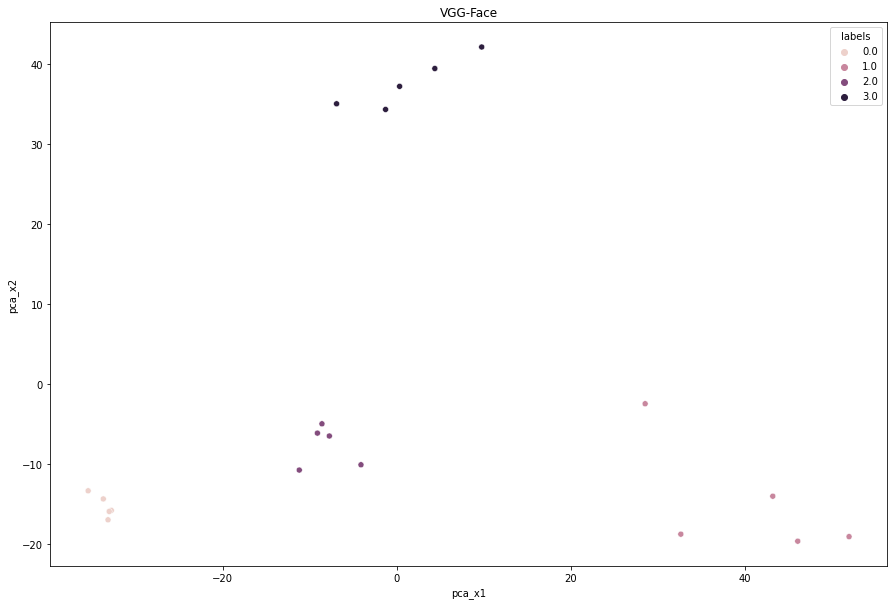

model name: Facenet embedding dimension: 129


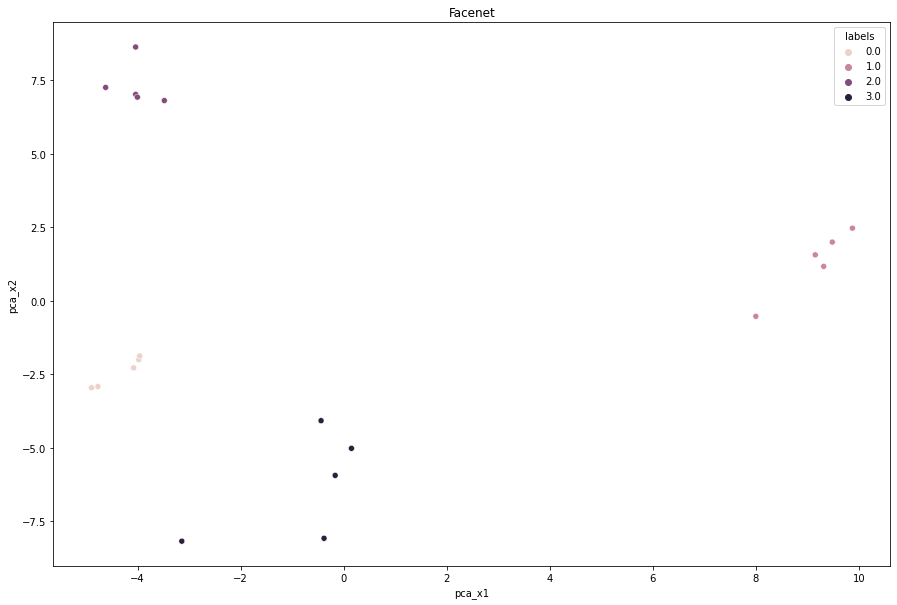

model name: Facenet512 embedding dimension: 513


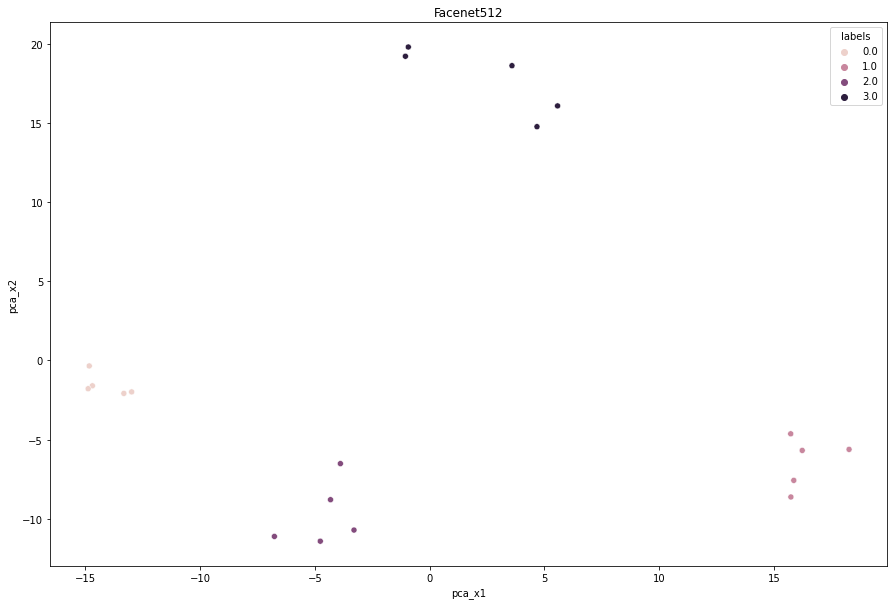

model name: OpenFace embedding dimension: 129


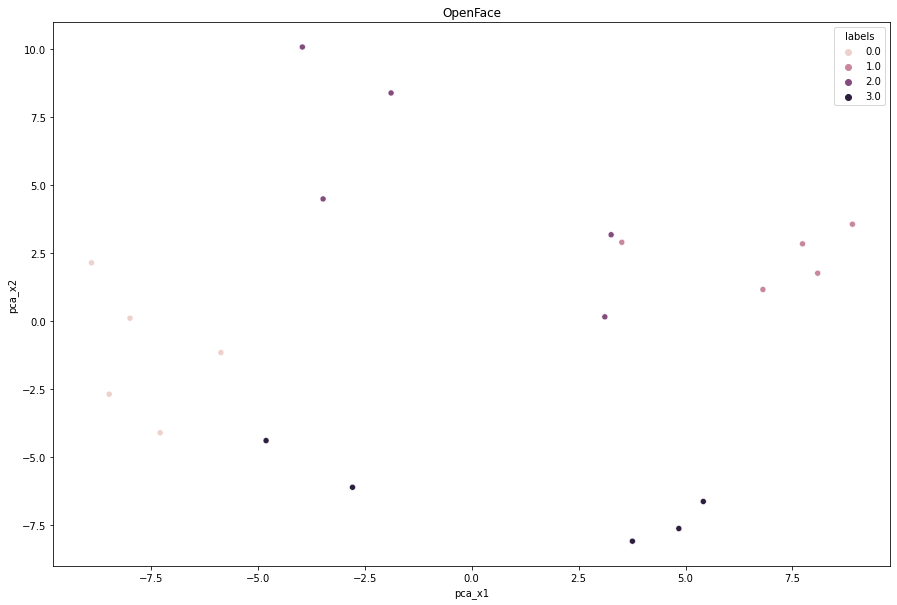

model name: DeepFace embedding dimension: 4097


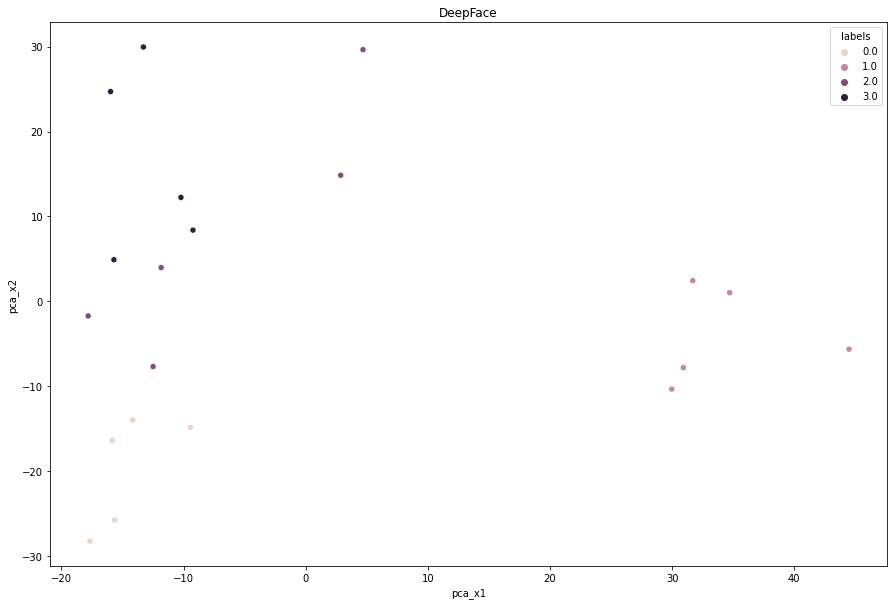

model name: DeepID embedding dimension: 161


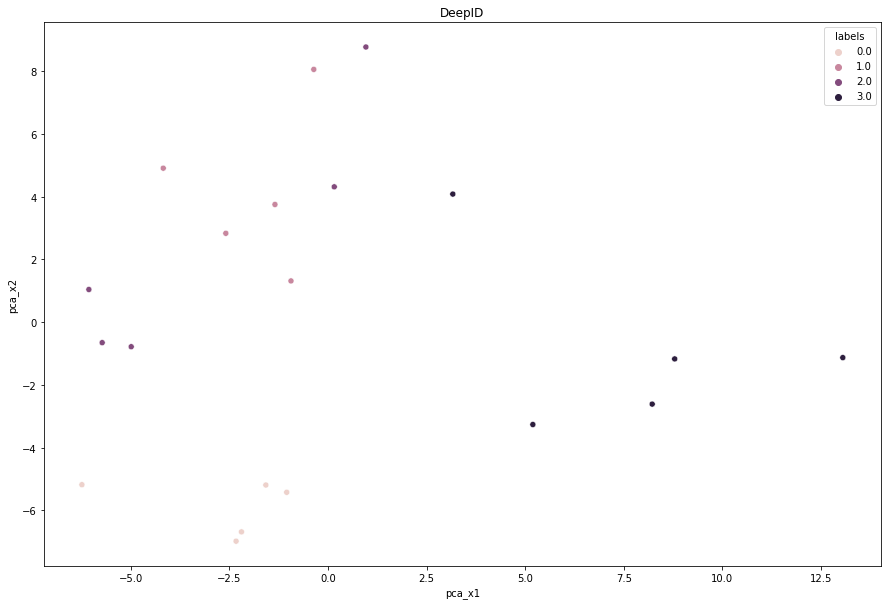

model name: ArcFace embedding dimension: 513


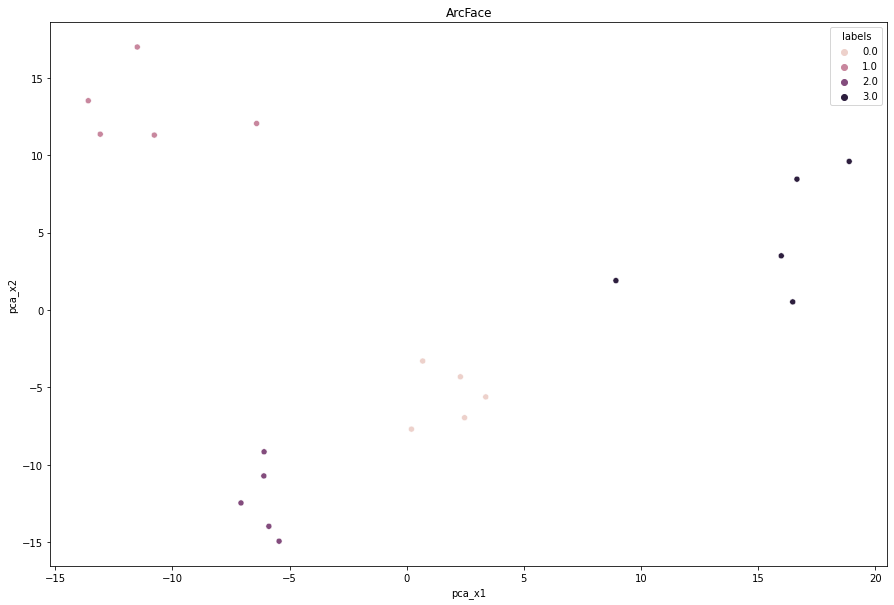

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import pca as pca

models = cfg['models']
save_folder_for_embedding_numpy = cfg['save_folder_for_embedding_numpy']
for model_num in range(len(models)):
    
  
  load_path = save_folder_for_embedding_numpy + 'emb_mat_' + models[model_num]+'.npy'
  emb_numpy_matrix = np.load(load_path, allow_pickle=True)
  print(f'model name: {models[model_num]} embedding dimension: {emb_numpy_matrix.shape[1]}')

  labels = emb_numpy_matrix[:, 0]
  emb_data = emb_numpy_matrix[:, 1:]
  # print(emb_data.shape)

  pca_x1, pca_x2 = pca.execute_pca(emb_data)
  
  combined_array = np.column_stack([pca_x1, pca_x2, labels])
  df_for_pca = pd.DataFrame(combined_array, columns = ['pca_x1', 'pca_x2', 'labels'])
  
  fig = plt.figure(1, figsize=(15, 10))
  sns.scatterplot(data = df_for_pca, x = 'pca_x1', y = 'pca_x2', hue = 'labels')
  title = models[model_num] + 'with ' + emb_numpy_matrix.shape[1] +' feature dimension'
  plt.title(models[model_num])
  plt.show()

In [ ]:
lis = []
test=[1,2,3]
for i in range(3):
  test.append(i)
  lis.append(np.array(test))
  
  
npa = np.asarray(lis)

print(npa.shape)
print(npa)

test = np.array([2,3,4])

final = np.hstack = ((npa, test))
print(final)

(3,)
[array([1, 2, 3, 0]) array([1, 2, 3, 0, 1]) array([1, 2, 3, 0, 1, 2])]
(array([array([1, 2, 3, 0]), array([1, 2, 3, 0, 1]),
       array([1, 2, 3, 0, 1, 2])], dtype=object), array([2, 3, 4]))
